<a href="https://colab.research.google.com/github/TiagolGoulart/GeoPython/blob/main/downloadCBERS4A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connecting with google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Installing the necessaries libraries

!pip install geopandas -q
!pip install rasterio -q
!pip install shapely -q
!pip install simplekml -q
!pip install cbers4asat[tools] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [3]:
!pip install numpy==1.23

  Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0


In [4]:
from cbers4asat.tools import clip

In [5]:
# Importing packages

import geopandas as gpd
import simplekml
import numpy as np
import rasterio
import os
import lxml.etree as etree
import pyproj
from pyproj import Transformer
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.features import shapes
from shapely.geometry import Polygon, Point

In [6]:
# Defining the data

# Define the coordinate system with EPSG code
sistema_coordenadas = input("Digite o código EPSG do sistema de coordenadas de referência: \n")
sistema_coordenadas = 'EPSG:'+sistema_coordenadas

# Path for mask to clip raster
kml_path = input('Cole o caminho para o kml que irá cortar as imagens raster: ')

# INPE user
user_cbers = input('Digite aqui seu e-mail de usuário cadastrado na plataforma do CBERS4A: \n')

# Inicial search date
inicial_date = input('Digite a data inicial de busca da imagem no formato DD/MM/AAAA: \n')
d_i = int(inicial_date[:2])
m_i = int(inicial_date[3:5])
a_i = int(inicial_date[6:])

# Final search date

final_date= input('Digite a data final de busca da imagem no formato DD/MM/AAAA: \n')
d_f = int(final_date[:2])
m_f = int(final_date[3:5])
a_f = int(final_date[6:])

# Setting the results output directory

out_dir = input('Cole o caminho da pasta onde os arquivos resultantes serão salvos: \n')

Digite o código EPSG do sistema de coordenadas de referência: 
32723
Cole o caminho para o kml que irá cortar as imagens raster: /content/drive/MyDrive/#TESTE/area_de_estudo.kml
Digite aqui seu e-mail de usuário cadastrado na plataforma do CBERS4A: 
tiagoo@alunos.utfpr.edu.br
Digite a data inicial de busca da imagem no formato DD/MM/AAAA: 
01/01/2022
Digite a data final de busca da imagem no formato DD/MM/AAAA: 
25/06/2023
Cole o caminho da pasta onde os arquivos resultantes serão salvos: 
/content/drive/MyDrive/#TESTE


In [7]:
# Opening the extension KML and setting the bbox

# Open the KML file in binary mode
with open(kml_path, 'rb') as f:
  kml_string = f.read()

# parse the KML string into an Element object
root = etree.fromstring(kml_string)

# Get the coordinates of the polygon
polygon = root.find('.//{http://www.opengis.net/kml/2.2}Polygon')
coords_str = polygon.find('.//{http://www.opengis.net/kml/2.2}coordinates').text

coords_list_original = [tuple(map(float, coord.split(',')[0:2])) for coord in coords_str.split()]
coords_list = [(coord[1], coord[0]) for coord in coords_list_original]

# Create a Transformer for the proper UTM projection
transformer = Transformer.from_crs("EPSG:4326", sistema_coordenadas)

# Convert the coordinates to the proper UTM projection
coords_list_utm = [transformer.transform(*coord)[::-1] for coord in coords_list]
coords_list = [(coord[1], coord[0]) for coord in coords_list_utm]

# Create a shapely polygon based on UTM coordinates for cutting
polygon_utm = Polygon(coords_list)

# Defining the mask based on the initial polygon
geo = polygon_utm

# Create a shapely polygon with geographic coordinates to get bbox
polygon_bbox = Polygon(coords_list_original)

# Using the 'envelope' attribute to get a bounding rectangle and then getting the max and min values
envelope = polygon_bbox.envelope
x_min, y_min, x_max, y_max = envelope.bounds

In [8]:
# Importing the libraries
from cbers4asat import Cbers4aAPI

# The date class is necessary to standardize the date format
from datetime import date

# Instantiating the object with the user registered on the platform
api = Cbers4aAPI(user_cbers)

# Bounding box formed by [x_min, y_min, x_max, y_max]
bbox=[x_min,y_min,x_max,y_max]

# Search interval
data_inicial = date(a_i,m_i,d_i)
data_final = date(a_f,m_f,d_f)


# Querying the catalog and displaying the results
produtos = api.query(location=bbox,
                     initial_date=data_inicial,
                     end_date=data_final,
                     cloud=100,
                     limit=1,
                     collections=['CBERS4A_WPM_L4_DN'])


In [9]:
# Viewing the data
produtos

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': 'CBERS4A_WPM19814220220304',
   'collection': 'CBERS4A_WPM_L4_DN',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-43.75, -22.4812],
      [-43.75, -23.5575],
      [-42.6161, -23.5575],
      [-42.6161, -22.4812],
      [-43.75, -22.4812]]]},
   'bbox': [-43.75, -23.5575, -42.6161, -22.4812],
   'properties': {'datetime': '2022-03-04T13:27:54',
    'path': 198,
    'row': 142,
    'satellite': 'CBERS4A',
    'sensor': 'WPM',
    'cloud_cover': 40.0,
    'sync_loss': None,
    'eo:gsd': -1,
    'eo:bands': [{'name': 'pan', 'common_name': 'pan'},
     {'name': 'blue', 'common_name': 'blue'},
     {'name': 'green', 'common_name': 'green'},
     {'name': 'red', 'common_name': 'red'},
     {'name': 'nir', 'common_name': 'nir'}]},
   'assets': {'pan': {'href': 'http://www2.dgi.inpe.br/api/download/TIFF/CBERS4A/2022_03/CBERS_4A_WPM_RAW_2022_03_04.13_21_30_ETC2/198_142_0/4_BC_UTM_WGS84/CBERS_4A_WPM_20220304_198

In [10]:
# Downloading the images for the output directory

api.download(products=produtos,
             bands=['green','blue','red','nir'],
             threads=10,
             outdir=out_dir)



In [15]:
# Definindo o caminho de cada imagem de banda

import time
import glob
start_time = time.time()  # Get the current time before starting the loop
timeout = 60  # Timeout in seconds

while True:
    try:
        blue_path = glob.glob(out_dir + '/*BAND1.tif')[0]
        green_path = glob.glob(out_dir + '/*BAND2.tif')[0]
        red_path = glob.glob(out_dir + '/*BAND3.tif')[0]
        nir_path = glob.glob(out_dir + '/*BAND4.tif')[0]

        break  # Exit the loop if no error occurs
    except IndexError:
        if time.time() - start_time >= timeout:
            print("Timeout: The timeout limit of 60 seconds has been reached."
            + "Please wait a moment and run the cell again.")
            break  # Exit the loop if the timeout is reached

In [16]:
# Definindo uma função de reprojeção dos rasters baixados

import rasterio
from rasterio.warp import calculate_default_transform, reproject
# input_file e output_file se referem aos caminhos de entrada e saída do raster inicial
# e do raster reprojetado, respectivamente, já o dst_crs é o sistema de referência desejado
# que deve ser digitado no padrão 'EPSG:4326' (WGS84 geográfico nesse caso)

def reproject_raster(input_file, output_file, dst_crs):
    # Abrindo o raster de entrada
    with rasterio.open(input_file) as src:
        # Calcula a transformação e dimensões para o raster reprojetado
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)

        # Cria o arquivo do raster de saída
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_file, 'w', **kwargs) as dst:
            # Reprojeta o raster de entrada para crs de saída
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=rasterio.enums.Resampling.nearest
            )

In [17]:
# Reprojetando os rasters com a função definida

blue_path_rprj = out_dir+'/RPRJ_BAND1.tif'
green_path_rprj = out_dir+'/RPRJ_BAND2.tif'
red_path_rprj = out_dir+'/RPRJ_BAND3.tif'
nir_path_rprj = out_dir+'/RPRJ_BAND4.tif'


reproject_raster(blue_path,
                 blue_path_rprj,
                 sistema_coordenadas)

reproject_raster(green_path,
                 green_path_rprj,
                 sistema_coordenadas)

reproject_raster(red_path,
                 red_path_rprj,
                 sistema_coordenadas)

reproject_raster(nir_path,
                 nir_path_rprj,
                 sistema_coordenadas)

In [18]:
# Recortando os rasters pela extensão do projeto



# Definindo a máscara com base no polígono inicial
geo = polygon_utm

from cbers4asat.tools import clip

out_dir_rec = out_dir+"/Recortados"

clip(
    raster=blue_path_rprj,
    mask=geo,
    outdir=out_dir_rec,
    filename="BAND1_REC.tif",
)

clip(
    raster=green_path_rprj,
    mask=geo,
    outdir=out_dir_rec,
    filename="BAND2_REC.tif",
)

clip(
    raster=red_path_rprj,
    mask=geo,
    outdir=out_dir_rec,
    filename="BAND3_REC.tif",
)

clip(
    raster=nir_path_rprj,
    mask=geo,
    outdir=out_dir_rec,
    filename="BAND4_REC.tif",
)

In [19]:
# Salvando os caminhos para os rasters em variáveis

blue_path=out_dir_rec+'/BAND1_REC.tif'
green_path=out_dir_rec+'/BAND2_REC.tif'
red_path=out_dir_rec+'/BAND3_REC.tif'
nir_path=out_dir_rec+'/BAND4_REC.tif'

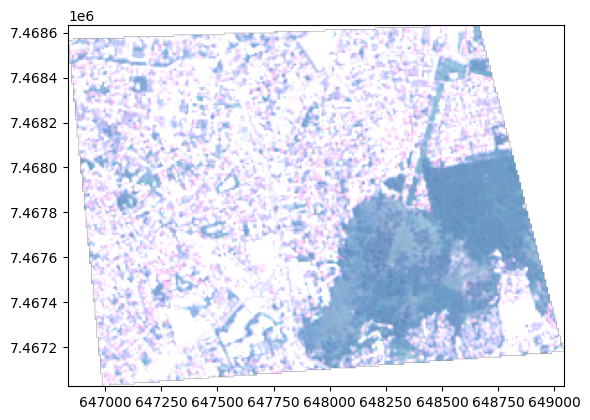

<Axes: >

In [25]:
# Exibindo a imagem da análise acima

from cbers4asat.tools import rgbn_composite
import rasterio as rio
from rasterio.plot import show

# Criando uma composição COR VERDADEIRA
# Cada parâmetro de cor representa o canal da imagem de saída
out_dir_RGB = '/content/drive/MyDrive/#FINAL_RESULT'

# Banda NIR é opcional
rgbn_composite(red=red_path,
               green=green_path,
               blue=blue_path,
               nir=nir_path,
               filename='TRUE_COLOR.tif',
               outdir=out_dir_RGB)

raster = rio.open(out_dir_RGB + "/TRUE_COLOR.tif")

show(raster.read(), transform=raster.transform)

In [26]:
import os

# Caminho da pasta inicial
pasta = out_dir

# Obtenha a lista de arquivos na pasta
arquivos = os.listdir(pasta)

# Percorra a lista de arquivos e exclua-os
for arquivo in arquivos:
    caminho_arquivo = os.path.join(pasta, arquivo)
    if os.path.isfile(caminho_arquivo):
        os.remove(caminho_arquivo)


# Caminho da pasta de recortados
pasta = out_dir_rec

# Obtenha a lista de arquivos na pasta
arquivos = os.listdir(pasta)

# Percorra a lista de arquivos e exclua-os
for arquivo in arquivos:
    caminho_arquivo = os.path.join(pasta, arquivo)
    if os.path.isfile(caminho_arquivo):
        os.remove(caminho_arquivo)